In [ ]:
### Solving Black Scholes PDE using NN

In [21]:
! pip install tensor

     |████████████████████████████████| 50 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 3.1 MB 37.2 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 9.7 MB/s  eta 0:00:01
     |████████████████████████████████| 296 kB 50.5 MB/s eta 0:00:01
     |████████████████████████████████| 259 kB 53.8 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 6.0 MB/s  eta 0:00:01
     |████████████████████████████████| 2.0 MB 58.8 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 10.8 MB/s eta 0:00:01
  Created wheel for tensor: filename=tensor-0.3.6-py3-none-any.whl size=71568 sha256=81eb8ebd213e2ac138394b6dbac37be4bfa81195e3491a2cb2e4b3cd95f9a007
  Stored in directory: /home/jovyan/.cache/pip/wheels/a8/4e/f1/bb2a5de7e97bf4cda65db23ca21cecc54772d9ecf065460983
  Created wheel for construct: filename=construct-2.10.68-py3-none-any.whl size=59210 sha256=bc9bddb1c0b13dbf839155f0b4c

In [11]:
import sys
import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt
import scipy.stats as si
sys.path.append("../../")

In [12]:
from pydens import Solver, D, V, ConvBlockModel
from pydens import NumpySampler as NS

In [13]:
def plot_loss(loss):
    plt.plot(loss)
    plt.grid()
    plt.xlabel('ITERATION', fontsize=16)
    plt.ylabel('L1-loss', fontsize=16)

In [14]:
def plot_approximation_1d(points, approximation, solution_function, savepath=None,
                          title=None, ylim=None):
    if isinstance(points, torch.Tensor):
        points = points.detach().numpy()
    if isinstance(approximation, torch.Tensor):
        approximation = approximation.detach().numpy()

    plt.plot(points, approximation, label='Neural Network approximation',
             linewidth=5, alpha=0.8)
    plt.plot(points, solution_function(points), label='Known analytical solution',
             linewidth=2)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$\hat{f}(x)$', fontsize=16)
    plt.grid()
    plt.legend(fontsize=12, loc=1)

    if ylim is not None:
        plt.ylim(ylim)

    if title is not None:
      plt.title(title, fontsize=16)

    if savepath is not None:
        plt.savefig(savepath, dpi=300)

In [15]:
def plot_approximation_2d(approximation):
    plt.imshow(approximation)
    plt.colorbar()
    plt.title(r'$\hat{f}(x, y)$', fontsize=16)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$y$', fontsize=16)

In [16]:
def cart_prod(*arrs):
    """ Get array of cartesian tuples from arbitrary number of arrays.
    """
    grids = np.meshgrid(*arrs, indexing='ij')
    return np.stack(grids, axis=-1).reshape(-1, len(arrs))

### Black-Schole PDE
$$ rs\frac{\partial v}{\partial s} + \frac{\partial v}{\partial t}  - \frac{1}{2} \frac{\partial^2 v}{\partial s^2} -rv = 0 \\
 u(s, t) = max(S-K)  s>0 \\
 u(0,t)=0\\
 {\frac{u(s,t)}{s}}=1 , s -> \infty $$
 
### Transformation from terminal to initial condition


https://www.mimuw.edu.pl/~apalczew/CFP_lecture6.pdf

Set $$x = \log(s)+(r-\frac{1}{2}\sigma ^{2})(T-t)\\
\gamma=\frac{\sigma ^{2}}{t}(T-t)$$

We then have heat equation where 

$$  \frac{\partial v}{\partial t} - \frac{\partial^2 v}{\partial x^2} =0$$

In [17]:
# INIT Conditions
r=0.01
s=100
k=120
vol=0.5
t=0.5
right='call'



In [18]:
 def euro_vanilla(s,k,t,r,vol,right):
        '''
        Given  Contract Properties ( underlying, strike, rate, expiration) returns the price of option
        
        '''
        d1 = (np.log(s / k) + (r + 0.5 *( vol ** 2)) * t) / (vol * np.sqrt(t)) #local d1, d2 for solving
        d2 = (np.log(s / k) + (r - 0.5 * (vol ** 2)) * t) / (vol* np.sqrt(t))
        
        if right == 'call':
            return (s * si.norm.cdf(d1, 0.0, 1.0) -  k* np.exp(-r * t) * si.norm.cdf(d2, 0.0, 1.0))
        else:
            return (k * np.exp(-r * t) * si.norm.cdf(-d2, 0.0, 1.0) - s  * si.norm.cdf(-d1, 0.0, 1.0))
         

In [19]:
euro_vanilla(s,k,t,r,vol,right)

7.562654747822169

In [70]:
def pde(v, x, t):
    return D(v,t)-D(D(v,x),x)

In [166]:
r=0.01
s=100
k=120
vol=0.5
t=0.5


solver = Solver(pde, ndims=2,
                 initial_condition=lambda x: torch.exp(torch.tensor(-r*T))*torch.tensor(torch.max(torch.exp(x)-k,torch.tensor(0)) ), # error when it is set to zero
                boundary_condition= torch.exp(torch.tensor(-r*(T-torch.tensor(2/(vol**2)*torch.tensor(t))))), layout='fafaf', units=[30, 40, 1], activation='Sigmoid')

<ipython-input-166-630db965f4fc>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boundary_condition= torch.exp(torch.tensor(-r*(T-torch.tensor(2/(vol**2)*torch.tensor(t))))), layout='fafaf', units=[30, 40, 1], activation='Sigmoid')
<ipython-input-166-630db965f4fc>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_condition=lambda x: torch.exp(torch.tensor(-r*T))*torch.tensor(torch.max(torch.exp(x)-k,torch.tensor(0)) ), # error when it is set to zero


### Issue is with iterating over BC

In [167]:
sampler = NS('u', dim=2) & NS('u', low=0, high=.5) &  NS('u', low=.1, high=4)

In [168]:
solver.fit(niters=1000, batch_size=1500, lr=0.005)

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-166-630db965f4fc>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_condition=lambda x: torch.exp(torch.tensor(-r*T))*torch.tensor(torch.max(torch.exp(x)-k,torch.tensor(0)) ), # error when it is set to zero
100%|██████████| 1000/1000 [00:08<00:00, 117.08it/s]


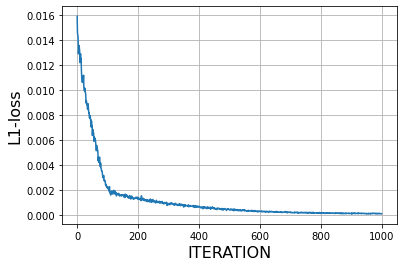

In [169]:
plot_loss(solver.losses[:])

In [170]:
# checking out the solution approximation for fixed epsilon
xs = torch.tensor(np.linspace(torch.log(torch.tensor(70)), torch.log(torch.tensor(200)), 100)).float()
eps = 4
approxs = solver.predict(xs, eps)

<ipython-input-166-630db965f4fc>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_condition=lambda x: torch.exp(torch.tensor(-r*T))*torch.tensor(torch.max(torch.exp(x)-k,torch.tensor(0)) ), # error when it is set to zero


<ipython-input-166-630db965f4fc>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_condition=lambda x: torch.exp(torch.tensor(-r*T))*torch.tensor(torch.max(torch.exp(x)-k,torch.tensor(0)) ), # error when it is set to zero


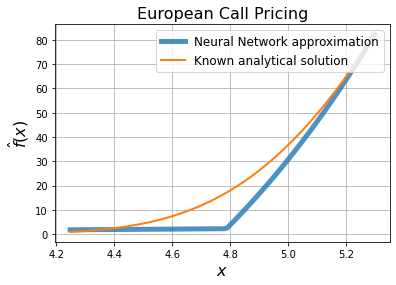

In [171]:
plot_approximation_1d(xs, solver.predict(xs, eps), lambda x: euro_vanilla(np.exp(x),k,t,r,vol,right),title='European Call Pricing')